In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [3]:
df = pd.read_csv('generated_time_series.csv')
data = df[['value']]

dataset = data.values
training_data_len = int(np.ceil(len(dataset) * 0.9))

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [5]:
n_steps = 60
train_data = scaled_data[0:int(training_data_len), :]
x_train = []
y_train = []

for i in range(n_steps, len(train_data)):
    x_train.append(train_data[i-n_steps:i, 0])
    y_train.append(train_data[i, 0])
        
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

<Axes: >

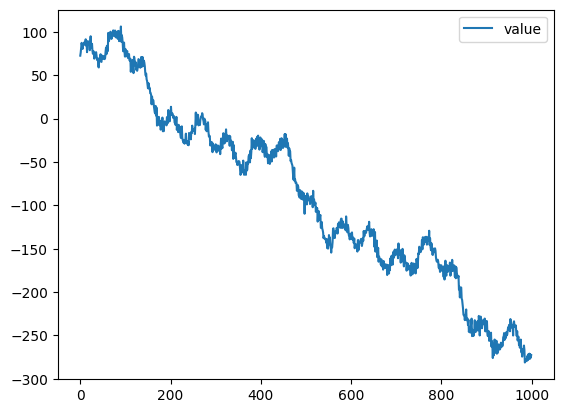

In [6]:
data.plot()

Обучим нейронную сеть LSTM, сделаем предсказания и посчитаем метрики

In [8]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=1)

840/840 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.0022


In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

test_data = scaled_data[training_data_len - n_steps: , :]

x_test = []
y_test = dataset[training_data_len:, :]
for i in range(n_steps, len(test_data)):
    x_test.append(test_data[i-n_steps:i, 0])
    
x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, predictions) * 100
r2 = r2_score(y_test, predictions)

print(f"R2: {r2}")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
R2: 0.5350120013272197
MAE: 7.3364498151447215
MSE: 77.98622853838981
RMSE: 8.83098117642597
MAPE: 2.8898333859825716%


In [10]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=2)

Epoch 1/2
840/840 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.0022
Epoch 2/2
840/840 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 8.4910e-04


In [11]:
test_data = scaled_data[training_data_len - n_steps: , :]

x_test = []
y_test = dataset[training_data_len:, :]
for i in range(n_steps, len(test_data)):
    x_test.append(test_data[i-n_steps:i, 0])
    
x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, predictions) * 100
r2 = r2_score(y_test, predictions)

print(f"R2: {r2}")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
R2: 0.722242530673413
MAE: 5.455944128261519
MSE: 46.58455173676728
RMSE: 6.825287666960806
MAPE: 2.1080592145699844%


LSTM научилась предсказывать временной ряд. Качество получилось неплохим. Модель не так сильно ошибается и понимает поведение ряда

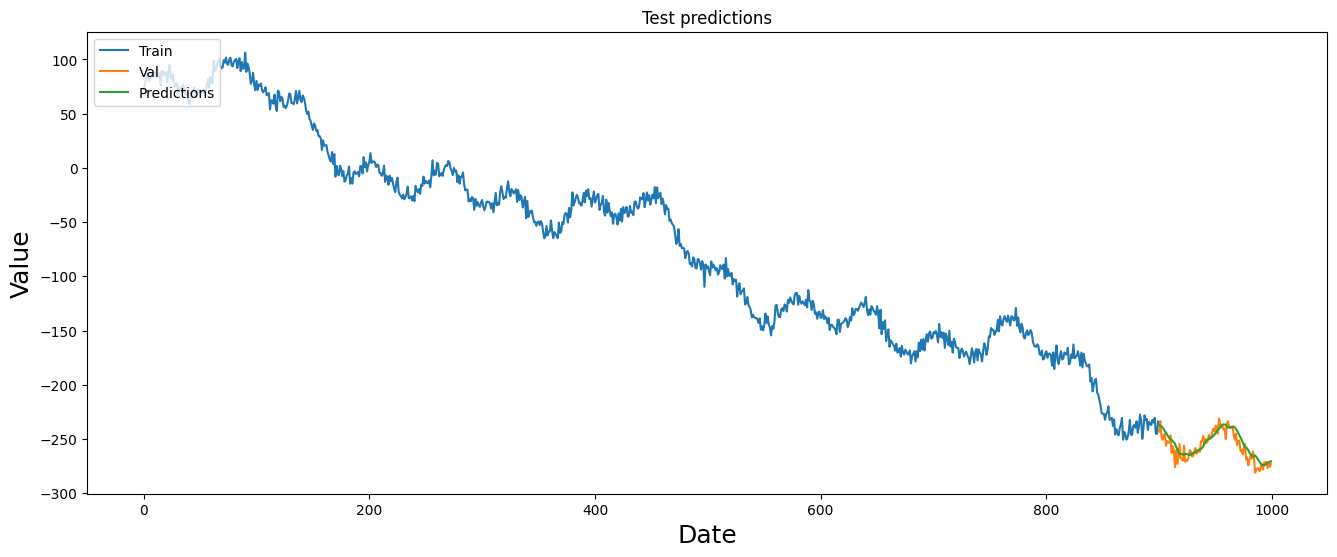

In [12]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,6))
plt.title('Test predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Value', fontsize=18)
plt.plot(train['value'])
plt.plot(valid[['value', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper left')
plt.show()

Предскажем дальнейшее поведение ряда и визуализируем

In [15]:
def forecast_future(model, last_sequence, scaler, n_future):
    future_predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_future):
        next_pred = model.predict(current_sequence.reshape(1, n_steps, 1), verbose=0)
        future_predictions.append(next_pred[0, 0])
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred[0, 0]
    
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    future_predictions = scaler.inverse_transform(future_predictions)
    
    return future_predictions.flatten()

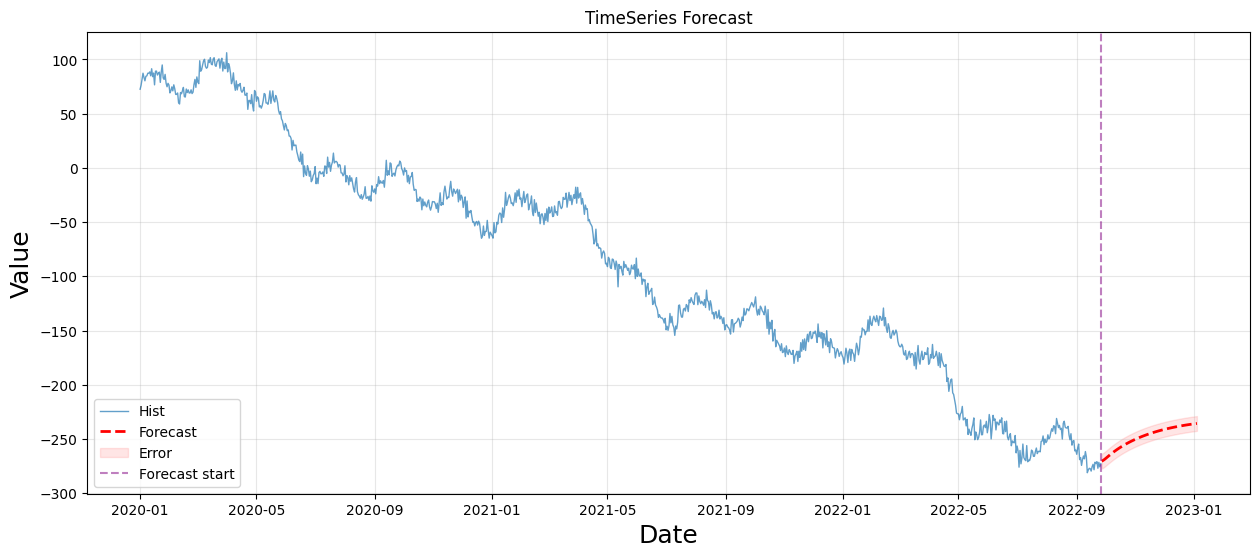

In [16]:
last_sequence_scaled = scaler.transform(df['value'].values[-n_steps:].reshape(-1, 1)).flatten()

n_future = 100
future_predictions = forecast_future(model, last_sequence_scaled, scaler, n_future)

df['date'] = pd.to_datetime(df['date'])
last_date = df.iloc[-1]['date']
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_future, freq='D')

plt.figure(figsize=(15, 6))
plt.plot(df["date"], df['value'], label='Hist', alpha=0.7, linewidth=1)
plt.plot(future_dates, future_predictions, label='Forecast', color='red', linewidth=2, linestyle='--')
plt.fill_between(future_dates, 
                 future_predictions - rmse, 
                 future_predictions + rmse, 
                 color='red', alpha=0.1, label='Error')

plt.axvline(x=last_date, color='purple', linestyle='--', alpha=0.5, label='Forecast start')

plt.title('TimeSeries Forecast')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Value', fontsize=18)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

судя по итоговому предсказанию и метрикам, нейронная сеть хуже справилась с моделированием временного ряда. Она очень сгладила его. Можно предположить, что такие резултаты связаны с тем, что ARIMA и другие статистические модели более пригодны для предсказания временных рядов, у которых мало данных.